In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
np.set_printoptions(precision=2, suppress=True)
plt.rcParams.update({'font.size': 14})

In [2]:
save_file = open('data0928/daily_data_matrix_all_0928.npy','rb')
raw_indicator = np.load(save_file)
raw_preds = np.load(save_file)
raw_conf = np.load(save_file)
raw_wager = np.load(save_file)
raw_se = np.load(save_file)
raw_truth = np.load(save_file)
raw_openday = np.load(save_file)
raw_user_type = np.load(save_file)
raw_user_id = np.load(save_file)
raw_preds_age = np.load(save_file)
save_file.close()

ifps_data = pd.read_csv("data0928/ifps0928_refined.csv")
raw_ifps_type = ifps_data['type'].values
labels = ['Volunteer', 'Turker', 'Control']

In [3]:
def corr(x, y):
    notnan_x = ~np.isnan(x)
    notnan_y = ~np.isnan(y)
    x = x[notnan_x & notnan_y]
    y = y[notnan_x & notnan_y]
    return st.pearsonr(x, y)

def marked_invalid_data_as_nan(data, openday):
    data = np.array(data, dtype=float)
    data[data<-0.1] = np.NAN
    data[openday<1] = np.NAN
    return data

In [7]:
# IFP filter
valid_IFPs = np.max(raw_openday[:, :], axis=0)>0
print(np.sum(valid_IFPs))
preds = raw_preds[:, valid_IFPs]
conf = raw_conf[:, valid_IFPs]
se = raw_se[:, valid_IFPs]
openday = raw_openday[:, valid_IFPs]
preds_age = raw_preds_age[:, valid_IFPs]
ifps_type = raw_ifps_type[valid_IFPs]
truth = raw_truth[valid_IFPs]
# User filter
user_type = np.array(raw_user_type)

190


In [5]:
marked_preds = marked_invalid_data_as_nan(preds, openday)
marked_conf = marked_invalid_data_as_nan(conf, openday)
marked_se = marked_invalid_data_as_nan(se, openday)


rel_marked_se = marked_se - np.nanmedian(marked_se, axis=2)[:, :, None]

#nan_mark = 1.0 * np.ones_like(openday)
#nan_mark[openday<-0.1] = np.NAN
#se_marked_with_nan *= nan_mark[:, :, None]
#avg_daily_se = np.nanmean(se_marked_with_nan, axis=0)

/Users/heliaguin/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:879: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [6]:
t, n, m, o = preds.shape
final_conf_per_IFP_user = np.NAN * np.ones((n,m))
final_preds_per_IFP_user = np.NAN * np.ones((n,m,o))
final_BS_per_IFP_user = np.NAN * np.ones((n,m))
last_day_per_IFP = np.argmax(openday, axis=0)
for i in range(n):
    if openday[last_day_per_IFP[i], i]<=0: continue
    final_conf_per_IFP_user[i] = marked_conf[last_day_per_IFP[i], i]
    final_preds_per_IFP_user[i] = marked_preds[last_day_per_IFP[i], i, :, :]
    final_BS_per_IFP_user[i] = marked_se[last_day_per_IFP[i], i, :]
#final_BS_per_IFP_user = se[-1]
avg_BS_per_IFP_user = np.nanmean(marked_se, axis=0)
print(final_BS_per_IFP_user.shape, avg_BS_per_IFP_user.shape)

(190, 2353) (190, 2353)


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


In [41]:
votes_per_IFP = np.zeros((n, o))
print(truth[ifps_type==2])
for i in range(n):
    for j in range(m):
        #if user_type[j]==2 and ~np.isnan(final_preds_per_IFP_user[i,j,0]):
        #    votes_per_IFP[i,np.argmax(final_preds_per_IFP_user[i,j])] += 1
        if user_type[j]>0 and preds[-1, i,j,0]>-0.1:
            votes_per_IFP[i,np.argmax(preds[-1, i,j])] += 1
            votes_per_IFP[i] += final_preds_per_IFP_user[i,j]
hits = np.argmax(votes_per_IFP[ifps_type==2], axis=1)==(truth[ifps_type==2]-1)
print(len(truth[ifps_type==2]))
print(np.sum(hits), 190-133-3)


[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  2.
  2.  1.  2.  2.  2.  1.  2.  1.  2.  2.  2.  1.  2.  2.  2.  1.  2.  2.
  2.  1.  1.  1.  2.  2.  1.  1.  2.  2.  1.  2.  1.  2.  2.  2.  2.  2.
  2.  2.  2.  1.  1.  1.  2.  2.  2.  2.  2.  1.  2.  2.  2.  2.  2.  1.
  2.  2.  2.  2.  2.  2.  1.  1.  2.  2.  2.  2.  2.  2.  2.]
87
79 54


In [95]:
open_period_per_IFP = 1.0 * np.max(openday[:,:], axis=0)
open_period_per_IFP[open_period_per_IFP<=0] = np.NAN

mean_final_preds_per_group_IFP = np.NAN * np.ones((3, n, o))
mean_final_conf_per_group_IFP = np.zeros((3, n))
mean_final_BS_per_group_IFP = np.zeros((3, n))
mean_avg_BS_per_group_IFP = np.zeros((3, n))

var_avg_BS_per_group_IFP = np.zeros((3, n))
var_final_preds_per_group_IFP = np.zeros((3, n))
for g in range(3):
    mean_final_preds_per_group_IFP[g] = np.nanmean(final_preds_per_IFP_user[:, user_type==g+1, :], axis=1)
    mean_final_conf_per_group_IFP[g] = np.nanmean(final_conf_per_IFP_user[:, user_type==g+1], axis=1)
    mean_final_BS_per_group_IFP[g] = np.nanmean(final_BS_per_IFP_user[:, user_type==g+1], axis=1)
    mean_avg_BS_per_group_IFP[g] = np.nanmean(avg_BS_per_IFP_user[:, user_type==g+1], axis=1)
    var_avg_BS_per_group_IFP[g] = np.nanvar(avg_BS_per_IFP_user[:, user_type==g+1], axis=1)
    tmp = np.nanvar(final_preds_per_IFP_user[:, user_type==g+1, :], axis=1)
    var_final_preds_per_group_IFP[g] = np.nansum(tmp, axis=-1)
    
mean_final_preds_per_group_IFP_binary = np.NAN * np.ones((3, n))
mean_final_preds_per_group_IFP_binary[:, ifps_type==2] = mean_final_preds_per_group_IFP[:, ifps_type==2, 0] 
var_avg_BS_per_group_IFP[var_avg_BS_per_group_IFP<=0.01] = np.NAN
var_final_preds_per_group_IFP[var_final_preds_per_group_IFP<=0.01] = np.NAN
print(var_final_preds_per_group_IFP.shape)

(3, 166)


/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  app.launch_new_instance()
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/heliaguin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal


In [100]:
raw_marked_preds = marked_invalid_data_as_nan(raw_preds, raw_openday)
votes_per_IFP = np.zeros((n, o))
print(raw_truth)
for i in range(n):
    for j in range(m):
        if ~np.isnan(final_preds_per_IFP_user[n,m,0]):
            votes_per_IFP[i,np.argmax(final_preds_per_IFP_user[n,m])] += 1
        

AttributeError: module 'numpy' has no attribute 'argnanmax'

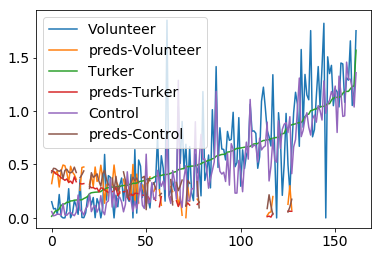

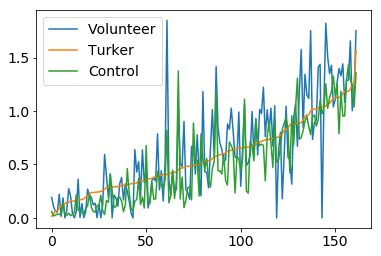

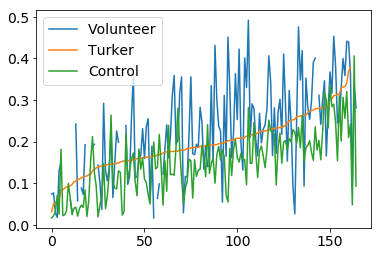

Final BS v.s. avg BS:
(0.99125018258767283, 1.2386716866484977e-142)
(0.99982515002815275, 1.9583210739544337e-278)
(0.99802920211402424, 2.6276116025061854e-194)
Correlation of final among groups:
(0.79068305998784449, 6.3893161538794367e-36)
(0.79185874043845816, 4.2847869503448376e-36)
(0.88548047678027497, 3.9392449656154446e-55)
Correlation of avg among groups:
(0.78791678983321289, 1.6195185926934847e-35)
(0.79420190171254534, 1.9174698479743466e-36)
(0.87886128567481281, 2.6835453041273032e-53)
Variance of final preds among groups:
(0.60135788393158118, 5.0835596561008301e-16)
(0.52757923873265034, 2.8755259680409813e-12)
(0.74201095745689616, 1.3765781863523576e-29)
Final BS v.s. variance of final predictions:
(0.51311680427901496, 2.2175052337915521e-11)
(0.70222538762270781, 3.0994015885748786e-25)
(0.74148780162347749, 1.5814200474334971e-29)
Final BS v.s. confidence of final predictions:
(-0.36517510851032897, 1.7706030519264887e-06)
(-0.55556064914773373, 1.677310451716976

/Users/heliaguin/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [98]:
order_on_IFP = np.argsort(mean_final_BS_per_group_IFP[1])
plt.figure(0)
for g in range(3):
    plt.plot(range(n), mean_final_BS_per_group_IFP[g][order_on_IFP], label=labels[g])
    plt.plot(range(n), np.abs(0.5 - mean_final_preds_per_group_IFP_binary[g, order_on_IFP]), 
             label = "preds-"+labels[g])
plt.legend()
plt.show()


order_on_IFP = np.argsort(mean_avg_BS_per_group_IFP[1])
plt.figure(1)
for g in range(3):
    plt.plot(range(n), mean_avg_BS_per_group_IFP[g][order_on_IFP], label=labels[g])
#plt.plot(range(n), var_final_preds_per_group_IFP[1][order_on_IFP], label = "Variance")
#plt.plot(range(n), open_period_per_IFP[order_on_IFP]/100, label = "open period")
plt.legend()
plt.show()

order_on_IFP = np.argsort(var_final_preds_per_group_IFP[1])
plt.figure(2)
for g in range(3):
    plt.plot(range(n), var_final_preds_per_group_IFP[g][order_on_IFP], label=labels[g])
#plt.plot(range(n), var_final_preds_per_group_IFP[1][order_on_IFP], label = "Variance")
#plt.plot(range(n), open_period_per_IFP[order_on_IFP]/100, label = "open period")
plt.legend()
plt.show()
plt.close('All')


print("Final BS v.s. avg BS:")
print(corr(mean_avg_BS_per_group_IFP[0], mean_final_BS_per_group_IFP[0]))
print(corr(mean_avg_BS_per_group_IFP[1], mean_final_BS_per_group_IFP[1]))
print(corr(mean_avg_BS_per_group_IFP[2], mean_final_BS_per_group_IFP[2]))

print("Correlation of final among groups:")
print(corr(mean_final_BS_per_group_IFP[0], mean_final_BS_per_group_IFP[1]))
print(corr(mean_final_BS_per_group_IFP[0], mean_final_BS_per_group_IFP[2]))
print(corr(mean_final_BS_per_group_IFP[1], mean_final_BS_per_group_IFP[2]))

print("Correlation of avg among groups:")
print(corr(mean_avg_BS_per_group_IFP[0], mean_avg_BS_per_group_IFP[1]))
print(corr(mean_avg_BS_per_group_IFP[0], mean_avg_BS_per_group_IFP[2]))
print(corr(mean_avg_BS_per_group_IFP[1], mean_avg_BS_per_group_IFP[2]))

print("Variance of final preds among groups:")
print(corr(var_final_preds_per_group_IFP[0], var_final_preds_per_group_IFP[1]))
print(corr(var_final_preds_per_group_IFP[0], var_final_preds_per_group_IFP[2]))
print(corr(var_final_preds_per_group_IFP[1], var_final_preds_per_group_IFP[2]))

print("Final BS v.s. variance of final predictions:")
print(corr(mean_final_BS_per_group_IFP[0], var_final_preds_per_group_IFP[0]))
print(corr(mean_final_BS_per_group_IFP[1], var_final_preds_per_group_IFP[1]))
print(corr(mean_final_BS_per_group_IFP[2], var_final_preds_per_group_IFP[2]))

print("Final BS v.s. confidence of final predictions:")
print(corr(mean_final_BS_per_group_IFP[0], mean_final_conf_per_group_IFP[0]))
print(corr(mean_final_BS_per_group_IFP[1], mean_final_conf_per_group_IFP[1]))
print(corr(mean_final_BS_per_group_IFP[2], mean_final_conf_per_group_IFP[2]))

print("Variance of final preds v.s. confidence of final predictions:")
print(corr(var_final_preds_per_group_IFP[0], mean_final_conf_per_group_IFP[0]))
print(corr(var_final_preds_per_group_IFP[1], mean_final_conf_per_group_IFP[1]))
print(corr(var_final_preds_per_group_IFP[2], mean_final_conf_per_group_IFP[2]))



#print("Avg BS v.s. variance of final predictions:")
#print(corr(mean_avg_BS_per_group_IFP[0], var_final_preds_per_group_IFP[0]))
#print(corr(mean_avg_BS_per_group_IFP[1], var_final_preds_per_group_IFP[1]))
#print(corr(mean_avg_BS_per_group_IFP[2], var_final_preds_per_group_IFP[2]))

#print(corr(mean_avg_BS_per_group_IFP[0], open_period_per_IFP))
#print(corr(mean_avg_BS_per_group_IFP[1], open_period_per_IFP))
#print(corr(mean_avg_BS_per_group_IFP[2], open_period_per_IFP))

print("Variance of final preds v.s. open period length")
print(corr(var_final_preds_per_group_IFP[0], open_period_per_IFP))
print(corr(var_final_preds_per_group_IFP[1], open_period_per_IFP))
print(corr(var_final_preds_per_group_IFP[2], open_period_per_IFP))



plt.close('All')